In [2]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [83]:
from numba import njit
@njit
def energyscore_multipletargets(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/ N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])**2)/(np.sum(y,axis=1)[:, np.newaxis])**2))/(2*N**2)
    return ES


In [4]:
# toy example
hosp = np.array([np.array([90, 96]), np.array([105, 110])])
case = np.array([np.array([950, 1001]), np.array([1100, 1030])])
death = np.array([np.array([5,6]), np.array([12,9])])

X1 = np.array([hosp[0], case[0], death[0]])
X2 = np.array([hosp[1], case[1], death[1]])
A = np.array([X1, X2])

obsh = np.array([100, 103])
obsc = np.array([1000, 999])
obsd = np.array([10, 11])

obs = np.array([obsh, obsc, obsd])
#X = np.array([hosp, case, death])

In [5]:
energyscore_multipletargets(A,obs)

0.15073861735596714

# Flu SMH Analysis

In [6]:
def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters  
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions


# Multi-dimensional energy score for MOBS model

In [45]:
# use Flu SMH data and shuffle trajectory matrices for hospitalizations in all states and calculate energy score
# for different matrix formulations

In [7]:
modelmap = {'MOBS_NEU-GLEAM_FLU':'Model A', 'NIH-Flu_TS': 'Model B','NotreDame-FRED':'Model C',
            'PSI-M2':'Model D', 'USC-SIkJalpha':'Model E', 'UT-ImmunoSEIRS':'Model F'}

In [8]:
#hospitalizations
target = 'hospitalization'
incidence=True
hosp = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target}.pq")
hosp['date'] = pd.to_datetime(hosp['date'])
hosp = hosp[(hosp.date>=pd.to_datetime('2023-09-09'))].sort_values(by=['date']).reset_index().drop(columns=\
                                                                        ['Unnamed: 0', 'index','weekly_rate'])

hosp = hosp[(hosp.location != '72') &(hosp.location!='66')]


In [9]:
modelsall = ['MOBS_NEU-GLEAM_FLU', 'NotreDame-FRED', 'USC-SIkJalpha', 'UT-ImmunoSEIRS',
                  'NIH-Flu_TS', 'PSI-M2']

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(hosp.date.max())


predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pull_flu_scenario_modeling_hub_predictions(model,'2023-09-03')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    
    numweeks = list(df.horizon.unique())
    start_date = list(df.origin_date.unique())[0]
    date_1 = pd.to_datetime(start_date)

    alldates = []
    for wk in numweeks:
        if wk==1:
            d = date_1 + timedelta(days=6*int(wk))
        else:
            d = pd.to_datetime("2023-09-02") + timedelta(weeks=int(wk))

        alldates.append(d)

    dfdates = pd.DataFrame({'horizon':numweeks, 'target_end_date':alldates}) # add date of prediction to dataframe
    df = df.merge(dfdates, how='inner', on='horizon')

    predictionsall = pd.concat([predictionsall, df])
    i += 1
    
    
# filter by dates with data
predictionsall = predictionsall[predictionsall.target_end_date <= max_date]    
     
    

In [246]:
dfmobs = predictionsall[(predictionsall.Model=='MOBS_NEU-GLEAM_FLU') & (predictionsall.target=='inc hosp')]

In [13]:
obs = np.array([np.array(hosp[hosp.location == i].value) for \
                     i in dfmobs.location.unique()])
locations = list(dfmobs.location.unique())

energyscores_locations = pd.DataFrame()

for it in range(50):
    print(it)
    for model in ['MOBS_NEU-GLEAM_FLU']:
        for scenario in ['A', 'B', 'C', 'D', 'E', 'F']:

            loc_array ={}
            j=0
            
            dfall = pd.DataFrame()
            for loc in locations:
                if loc in ['72', '66']:
                    continue
                predictionshosp = dfmobs[(dfmobs.scenario_id == scenario + '-2023-08-14') & \
                                            (dfmobs.target_end_date <= hosp.date.max()) & \
                                            (dfmobs.target_end_date >= hosp.date.min())&\
                                            (dfmobs.Model == model) &\
                                            (dfmobs.location==loc)]

                newid = random.sample(list(predictionshosp['trajectory_id'].unique()), 
                                      k=len(list(predictionshosp['trajectory_id'].unique())))
                predictionshosp['new_id'] = predictionshosp['trajectory_id'].apply(lambda key: newid[key-1])

                dfall = pd.concat([dfall,predictionshosp])
                
            tlist = []
            for tid in dfall.new_id.unique():
                dfilt = dfall[dfall.new_id==tid]
                llist = []
                for loc in dfilt.location.unique():
                    d = dfilt[dfilt.location==loc].sort_values(by='target_end_date')
                    llist.append(list(d.value))
                    
                tlist.append(llist)
                

            A = np.array(tlist)

            ES = energyscore_multipletargets(A,obs)


            newrow = pd.DataFrame({'Model':model , 'Label': 'Scenario '+ scenario, 'location':'US',  
                                 'energyscore': ES, 'it':it}, index=[0])

            energyscores_locations = pd.concat([energyscores_locations, newrow])

energyscores_locations = energyscores_locations.reset_index().drop(columns=['index'])  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [14]:
energyscores_locations.to_csv('../fludat/multitarget_loc_MOBS_1204.csv')

In [3]:
baseline = pd.read_csv('../fludat/multitarget_loc_baseline_1204.csv')
baselinemed = baseline.energyscore.median()

energyscores_locations = pd.read_csv('../fludat/multitarget_loc_MOBS_1204.csv')
energyscores_locations['ES_ratio'] = energyscores_locations['energyscore'] / baselinemed


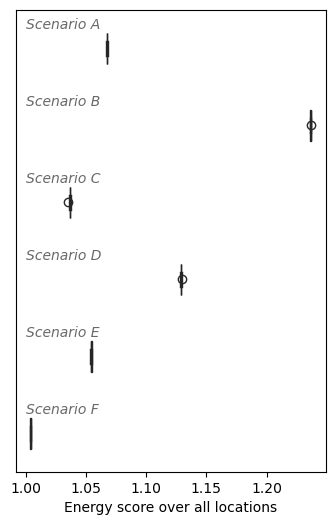

In [5]:
# plot multi-target energy score across all locations just for MOBS model
fig, ax = plt.subplots(1,1,figsize=(4,6), sharex=True)

my_order = list(energyscores_locations.Label.unique())
sns.boxplot(x='ES_ratio', y='Label', data=energyscores_locations, width=.4, showfliers=True, color='teal')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Energy score over all locations')

a=0
for mod in list(my_order):
    plt.text(1,a-.25, mod, fontsize=10, style='italic', color='dimgray')
    a+=1



#plt.savefig('../figs/mulitargets_locations_MOBS.pdf')

In [17]:
energyscores_locations.groupby('Label').median().to_csv('../fludat/multitarget_mobs_ratio_median_1204.csv')

In [245]:
energyscores_locations =pd.read_csv('../fludat/multitarget_loc_MOBS_1204.csv')

In [29]:
df_describe = energyscores_locations.drop(columns=['Unnamed: 0', 'location', 'it',
                                                   'Model']).groupby('Label').describe()['energyscore']

df_describe['range'] = df_describe['max'] - df_describe['min']
df_describe = df_describe.round(3)

In [30]:
df_describe

,count,mean,std,min,25%,50%,75%,max,range
Label,,,,,,,,,
Scenario A,50.0,0.868,0.0,0.867,0.867,0.868,0.868,0.868,0.002
Scenario B,50.0,1.005,0.0,1.004,1.005,1.005,1.005,1.005,0.001
Scenario C,50.0,0.843,0.0,0.841,0.842,0.843,0.843,0.843,0.002
Scenario D,50.0,0.917,0.0,0.917,0.917,0.917,0.918,0.918,0.001
Scenario E,50.0,0.857,0.0,0.856,0.857,0.857,0.857,0.858,0.002
Scenario F,50.0,0.816,0.0,0.815,0.816,0.816,0.816,0.817,0.001


In [21]:
df_describe.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &  count &  mean &  std &   min &   25\\% &   50\\% &   75\\% &   max &  range \\\\\nLabel      &        &       &      &       &       &       &       &       &        \\\\\n\\midrule\nScenario A &   50.0 &  0.87 &  0.0 &  0.87 &  0.87 &  0.87 &  0.87 &  0.87 &    0.0 \\\\\nScenario B &   50.0 &  1.00 &  0.0 &  1.00 &  1.00 &  1.00 &  1.01 &  1.01 &    0.0 \\\\\nScenario C &   50.0 &  0.84 &  0.0 &  0.84 &  0.84 &  0.84 &  0.84 &  0.84 &    0.0 \\\\\nScenario D &   50.0 &  0.92 &  0.0 &  0.92 &  0.92 &  0.92 &  0.92 &  0.92 &    0.0 \\\\\nScenario E &   50.0 &  0.86 &  0.0 &  0.86 &  0.86 &  0.86 &  0.86 &  0.86 &    0.0 \\\\\nScenario F &   50.0 &  0.82 &  0.0 &  0.82 &  0.82 &  0.82 &  0.82 &  0.82 &    0.0 \\\\\n\\bottomrule\n\\end{tabular}\n'